# Task 1

## P1 

In [67]:
import math
import numpy as np 
    
def replicas(x, y, L):
    """
    Function to generate replicas of a single particle.
    
    Parameters
    ==========
    x, y : Position.
    L : Side of the squared arena.
    """    
    xr = np.zeros(9)
    yr = np.zeros(9)

    for i in range(3):
        for j in range(3):
            xr[3 * i + j] = x + (j - 1) * L
            yr[3 * i + j] = y + (i - 1) * L
    
    return xr, yr

In [68]:
def pbc(x, y, L):
    """
    Function to enforce periodic boundary conditions on the positions.
    
    Parameters
    ==========
    x, y : Position.
    L : Side of the squared arena.
    """   
    
    outside_left = np.where(x < - L / 2)[0]
    x[outside_left] = x[outside_left] + L

    outside_right = np.where(x > L / 2)[0]
    x[outside_right] = x[outside_right] - L

    outside_up = np.where(y > L / 2)[0]
    y[outside_up] = y[outside_up] - L

    outside_down = np.where(y < - L / 2)[0]
    y[outside_down] = y[outside_down] + L
    
    return x, y

In [69]:
from functools import reduce

def interaction(x, y, theta, Rf, L):
    """
    Function to calculate the orientation at the next time step.
    
    Parameters
    ==========
    x, y : Positions.
    theta : Orientations.
    Rf : Flocking radius.
    L : Dimension of the squared arena.
    s : Discrete steps.
    """
    
    N = np.size(x)

    theta_next = np.zeros(N)
    
    # Preselect what particles are closer than Rf to the boundaries.
    replicas_needed = reduce( 
        np.union1d, (
            np.where(y + Rf > L / 2)[0], 
            np.where(y - Rf < - L / 2)[0],
            np.where(x + Rf > L / 2)[0],
            np.where(x - Rf > - L / 2)[0]
        )
    )

    for j in range(N):
        # Check if replicas are needed to find the nearest neighbours.
        if np.size(np.where(replicas_needed == j)[0]):
            # Use replicas.
            xr, yr = replicas(x[j], y[j], L)
            nn = []
            for nr in range(9):
                dist2 = (x - xr[nr]) ** 2 + (y - yr[nr]) ** 2 
                nn = np.union1d(nn, np.where(dist2 <= Rf ** 2)[0])
        else:
            dist2 = (x - x[j]) ** 2 + (y - y[j]) ** 2 
            nn = np.where(dist2 <= Rf ** 2)[0]
        
        # The list of nearest neighbours is set.
        nn = nn.astype(int)
        
        # Circular average.
        av_sin_theta = np.mean(np.sin(theta[nn]))
        av_cos_theta = np.mean(np.cos(theta[nn]))
        
        theta_next[j] = np.arctan2(av_sin_theta, av_cos_theta)
                   
    return theta_next

In [70]:
from scipy.spatial import Voronoi, voronoi_plot_2d

def area_polygon(vertices):
    """
    Function to calculate the area of a Voronoi region given its vertices.
    
    Parameters
    ==========
    vertices : Coordinates (array, 2 dimensional).
    """    
    
    N, dim = vertices.shape
    
    # dim is 2.
    # Vertices are listed consecutively.
    
    A = 0
    
    for i in range(N-1):
        # Below is the formula of the area of a triangle given the vertices.
        A += np.abs(
            vertices[- 1, 0] * (vertices[i, 1] - vertices[i + 1, 1]) +
            vertices[i, 0] * (vertices[i + 1, 1] - vertices[- 1, 1]) +
            vertices[i + 1, 0] * (vertices[- 1, 1] - vertices[i, 1])
        )
    
    A *= 0.5
    
    return A


def global_clustering(x, y, Rf, L):
    """
    Function to calculate the global alignment coefficient.
    
    Parameters
    ==========
    x, y : Positions.
    Rf : Flocking radius.
    L : Dimension of the squared arena.
    """
    
    N = np.size(x)
    
    # Use the replicas of all points to calculate Voronoi for 
    # a more precise estimate.
    points = np.zeros([9 * N, 2])

    for i in range(3):
        for j in range(3):
            s = 3 * i + j
            points[s * N:(s + 1) * N, 0] = x + (j - 1) * L
            points[s * N:(s + 1) * N, 1] = y + (i - 1) * L

    # The format of points is the one needed by Voronoi.
    # points[:, 0] contains the x coordinates
    # points[:, 1] contains the y coordinates
   
    vor = Voronoi(points)     
    '''
    vertices = vor.vertices  # Voronoi vertices.
    regions = vor.regions  # Region list. 
    # regions[i]: list of the vertices indices for region i.
    # If -1 is listed: the region is open (includes point at infinity).
    point_region = vor.point_region  # Region associated to input point.
    '''
   
    # Consider only regions of original set of points (no replicas).
    list_regions = vor.point_region[4 * N:5 * N]
    
    c = 0

    for i in list_regions:
        indices = vor.regions[i]
        # print(f'indices = {indices}')
        if len(indices) > 0:
            if np.size(np.where(np.array(indices) == -1)[0]) == 0:
                # Region is finite.
                # Calculate area.
                A = area_polygon(vor.vertices[indices,:])
                if A < np.pi * Rf ** 2:
                    c += 1
                    
    c = c / N
                   
    return c

In [71]:
def global_alignment(theta):
    """
    Function to calculate the global alignment coefficient.
    
    Parameters
    ==========
    theta : Orientations.
    """
    
    N = np.size(theta)
    
    global_direction_x = np.sum(np.sin(theta))
    global_direction_y = np.sum(np.cos(theta))
        
    psi = np.sqrt(global_direction_x ** 2 + global_direction_y ** 2) / N
    
                   
    return psi

In [72]:
N_part = 200 
L = 100 
v = 1  
Rf = 2 
eta = 0.01  
dt = 1  

x = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]
y = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]

theta = 2 * (np.random.rand(N_part) - 0.5) * np.pi  # in [-pi, pi]


In [ ]:
import time
from scipy.constants import Boltzmann as kB 
from tkinter import *


step = 0
t_tot = 6000

config_x1 = []
config_y1 = []
config_theta1 = []

psi = np.zeros(t_tot+1) 
c = np.zeros(t_tot+1)

while step <= t_tot: 
    psi[step] = global_alignment(theta)
    c[step] = global_clustering(x, y, Rf, L)
    
    # Calculate next theta from the rule.
    dtheta = eta * (np.random.rand(N_part) - 0.5) * dt
    ntheta = interaction(x, y, theta, Rf, L) + dtheta
    nx = x + v * np.cos(ntheta)
    ny = y + v * np.sin(ntheta)
    
    # Reflecting boundary conditions.
    nx, ny = pbc(nx, ny, L)

    if(step == 0 or step == 2000 or step == 4000 or step == 6000):
        config_x1.append(nx[:])
        config_y1.append(ny[:])
        config_theta1.append(ntheta[:])

    step += 1
    if step % 100 == 0:
        print(step)
        
    x[:] = nx[:]
    y[:] = ny[:]
    theta[:] = ntheta[:]  




100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000


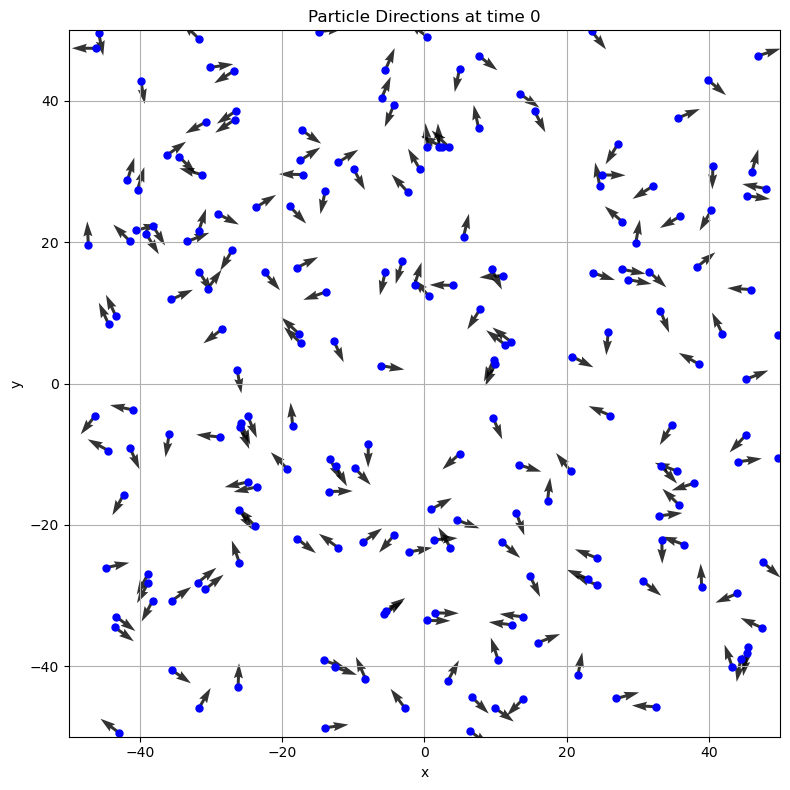

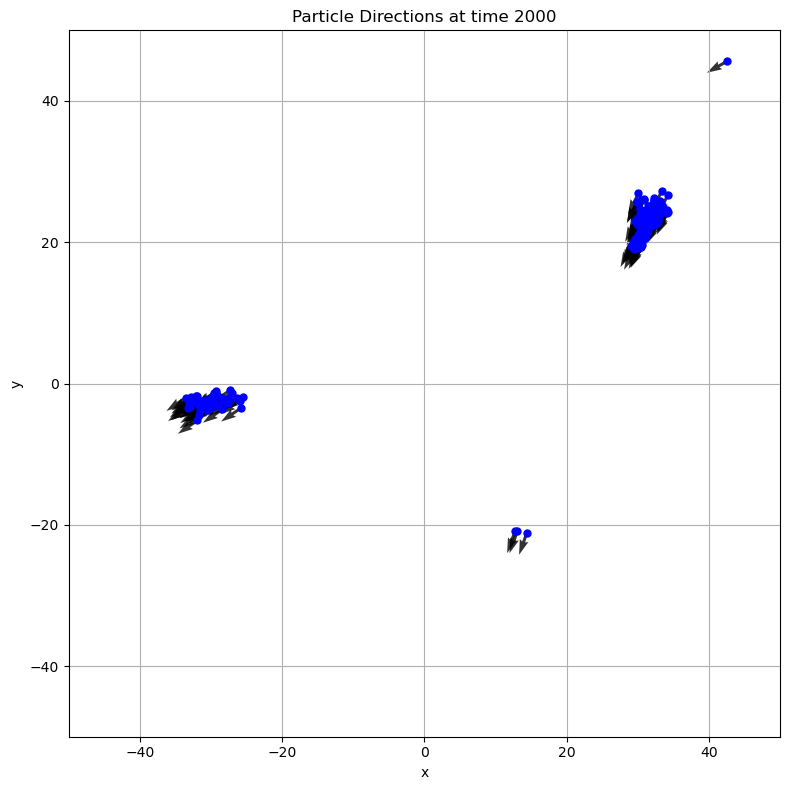

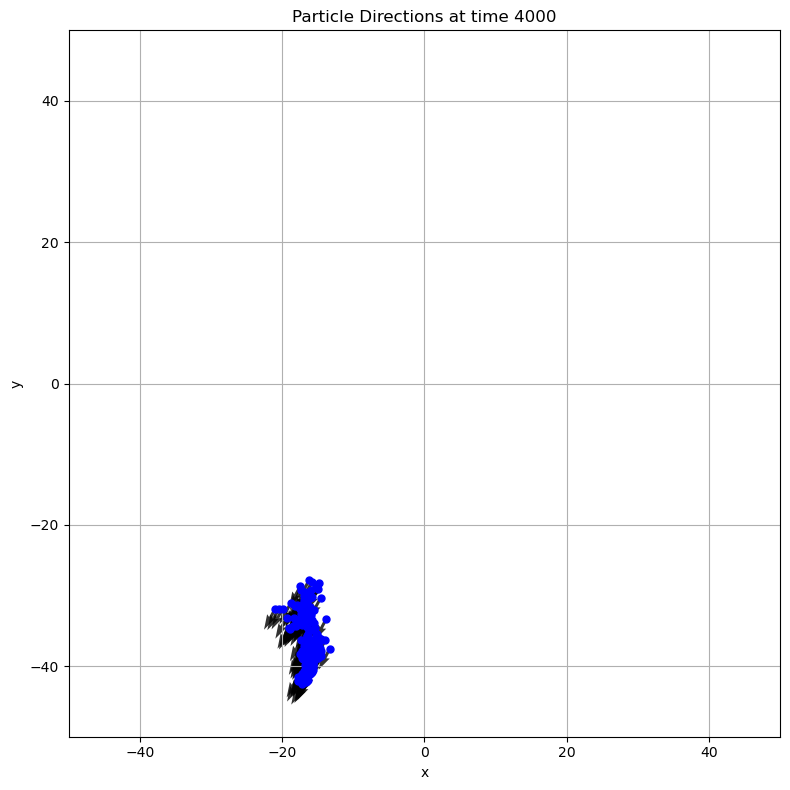

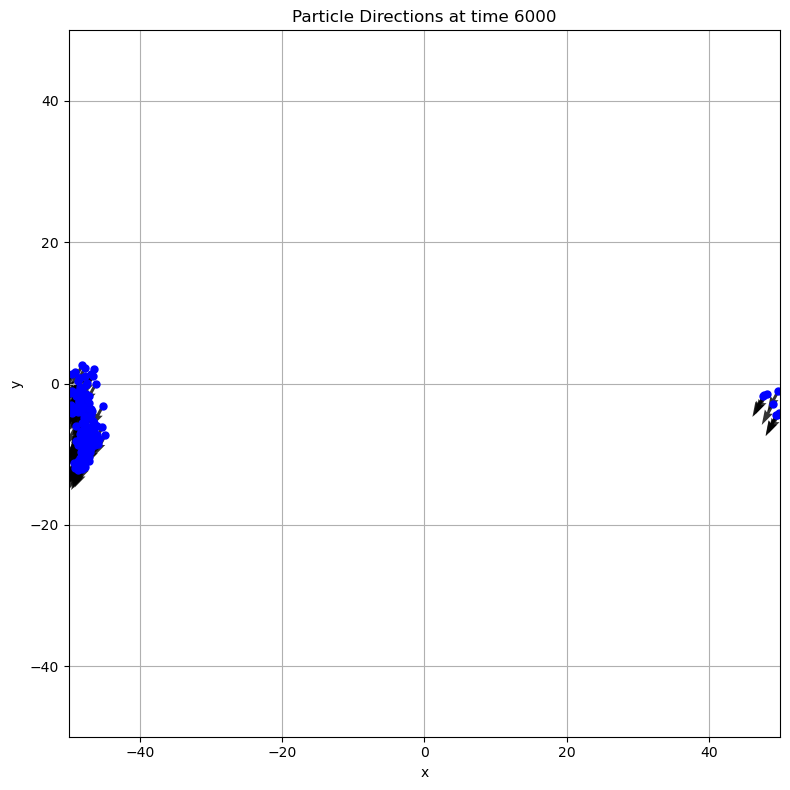

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Prepare time steps corresponding to snapshots
time_steps = [0, 2000, 4000, 6000]

# Plot arrows representing particle directions at each snapshot
for i, time in enumerate(time_steps):
    plt.figure(figsize=(8, 8))
    x_positions_p1 = config_x1[i]
    y_positions_p1 = config_y1[i]
    angles = config_theta1[i]

    u_p1 = np.cos(angles)
    v_p1 = np.sin(angles)

    plt.plot(x_positions_p1, y_positions_p1, '.', color='blue', markersize=10)
    plt.quiver(x_positions_p1, y_positions_p1, u_p1, v_p1, color='black', angles='xy', scale_units='xy', scale=0.3, alpha=0.8)
    """plt.scatter(x_positions_p1, y_positions_p1 )
    for j in range(len(x_positions_p1)):
        plt.arrow(x_positions_p1[j], y_positions_p1[j], u[j], v[j])"""
    plt.title(f'Particle Directions at time {time}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.xlim([-L/2,L/2])
    plt.ylim([-L/2,L/2])
    plt.tight_layout()
    plt.show()


## P2 

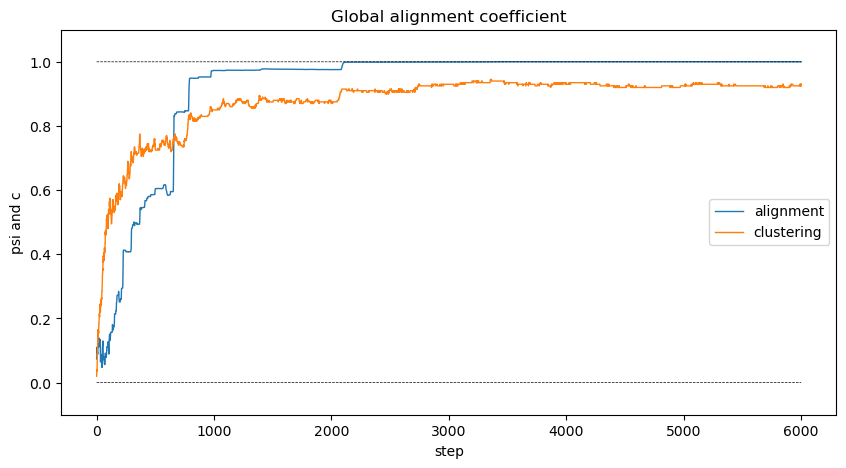

In [75]:

from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(psi, '-', linewidth=1, label='alignment')
plt.plot(c, '-', linewidth=1, label='clustering')
plt.plot(0 * psi, '--', color='k', linewidth=0.5)
plt.plot(0 * psi + 1, '--', color='k', linewidth=0.5)
plt.title('Global alignment coefficient')
plt.legend()
plt.xlabel('step')
plt.ylabel('psi and c')
plt.ylim([-0.1, 1.1])
plt.show()

# Task 2

## P3 

In [76]:
N_part = 200  
L = 100  
v = 1  
Rf = 2  
eta1 = 0.01  
eta2 = 0.3
dt = 1  

x = (np.random.rand(N_part) - 0.5) * L  
y = (np.random.rand(N_part) - 0.5) * L  

# Random orientation.
theta = 2 * (np.random.rand(N_part) - 0.5) * np.pi  

In [ ]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import time

step = 0
t_tot = 6000
half_N = N_part // 2

config_x = []
config_y = []
config_theta = []

psi2 = np.zeros(t_tot+1) 
c2 = np.zeros(t_tot+1)
fig, ax = plt.subplots(figsize=(10, 10))

while step <= t_tot: 
    
    """ if step % 1 == 0:
        ax.clear()  # Clear previous plot.
        
        # Plot first subpopulation
        ax.plot(x[:half_N], y[:half_N], '.', markersize=10, color='blue', label='Subpopulation 1')
        ax.quiver(x[:half_N], y[:half_N], np.cos(theta[:half_N]), np.sin(theta[:half_N]), color='blue', scale=30)
        
        # Plot second subpopulation
        ax.plot(x[half_N:], y[half_N:], '.', markersize=10, color='red', label='Subpopulation 2')
        ax.quiver(x[half_N:], y[half_N:], np.cos(theta[half_N:]), np.sin(theta[half_N:]), color='red', scale=30)

        # Plot boundary (if needed)
        ax.plot(Rf * np.cos(2 * np.pi * np.arange(360) / 360),
                Rf * np.sin(2 * np.pi * np.arange(360) / 360),
                '-', color='#FFA0FF', linewidth=3)
        
        ax.set_xlim([-L / 2, L / 2])
        ax.set_ylim([-L / 2, L / 2])
        ax.set_title(f'Step {step}')
        ax.legend(loc='upper right')  # Add legend to distinguish subpopulations
        
        display(fig)  # Display updated plot.
        clear_output(wait=True)  # Clear previous output."""
        
    psi2[step] = global_alignment(theta)
    c2[step] = global_clustering(x, y, Rf, L)
    
    dtheta = np.zeros(N_part)
    
    dtheta[:half_N] = eta1 * (np.random.rand(half_N) - 0.5) * dt
    dtheta[half_N:] = eta2 * (np.random.rand(N_part-half_N) - 0.5) * dt

    ntheta = interaction(x, y, theta, Rf, L) + dtheta
    nx = x + v * np.cos(ntheta)
    ny = y + v * np.sin(ntheta)
    
    # Reflecting boundary conditions.
    nx, ny = pbc(nx, ny, L)

    if(step == 0 or step == 2000 or step == 4000 or step == 6000):
        config_x.append(nx[:])
        config_y.append(ny[:])
        config_theta.append(ntheta[:])

    step += 1
    if step % 100 == 0:
        print(step)
        
    x[:] = nx[:]
    y[:] = ny[:]
    theta[:] = ntheta[:]  




100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200


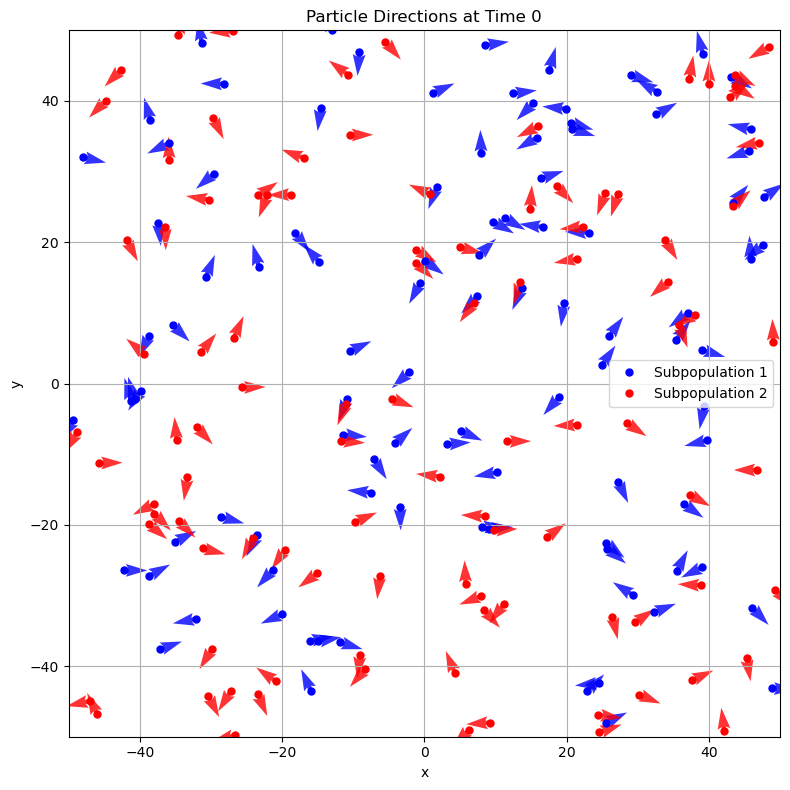

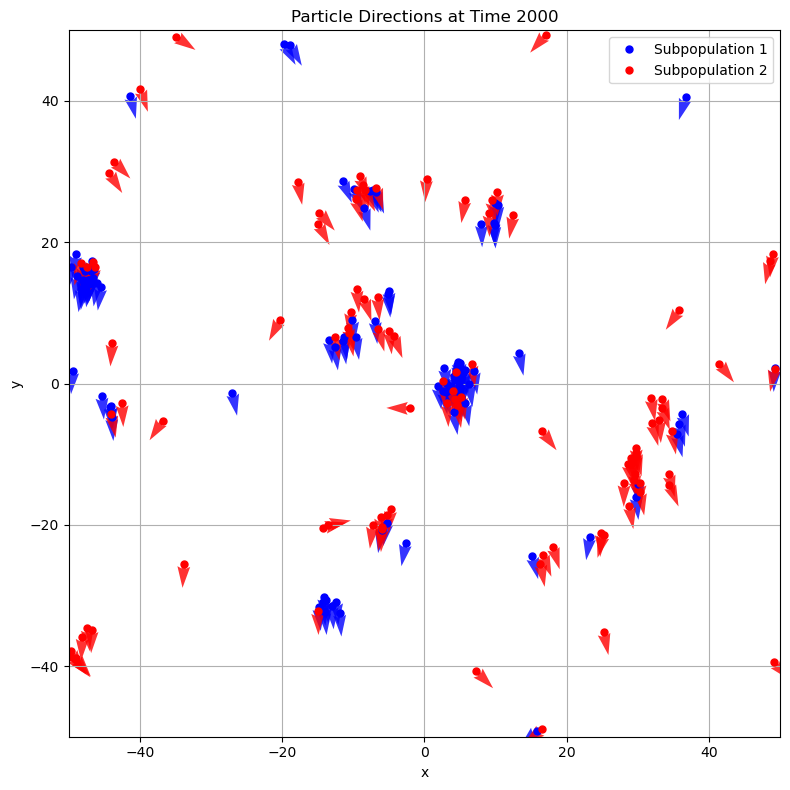

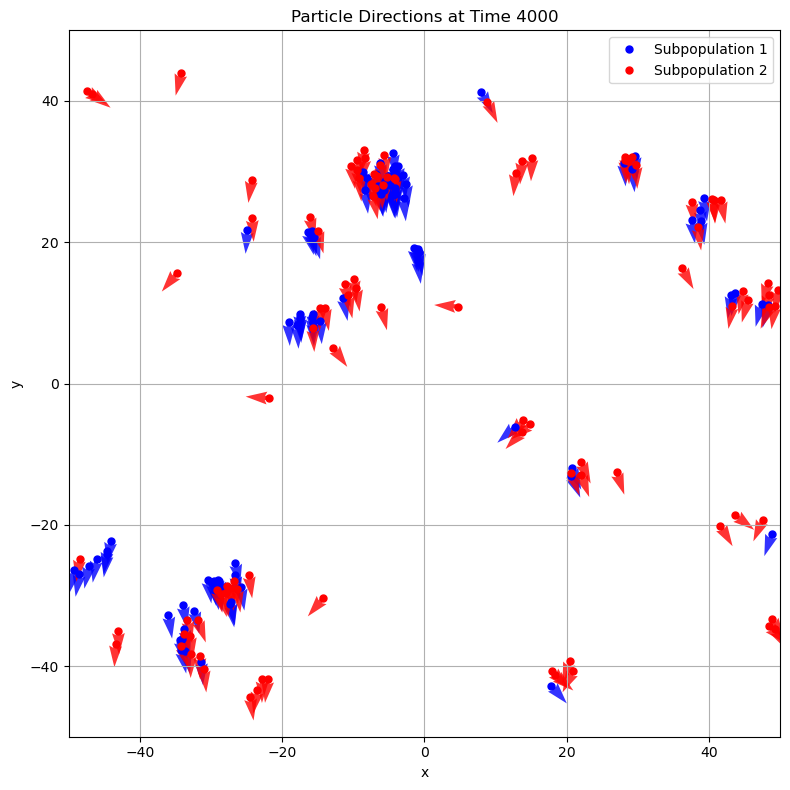

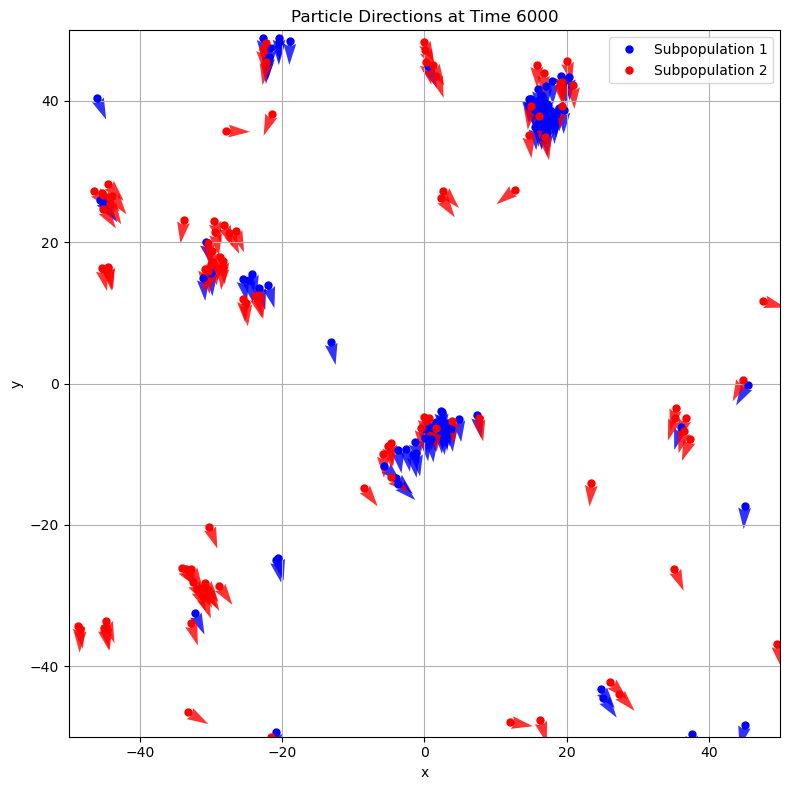

In [ ]:

time_steps = [0, 2000, 4000, 6000]
N_half = N_part // 2  

for i, time in enumerate(time_steps):
    plt.figure(figsize=(8, 8))

    x_positions = config_x[i]
    y_positions = config_y[i]
    angles = config_theta[i]

    x_positions_1, x_positions_2 = x_positions[:N_half], x_positions[N_half:]
    y_positions_1, y_positions_2 = y_positions[:N_half], y_positions[N_half:]
    angles_1, angles_2 = angles[:N_half], angles[N_half:]

    u1, v1 = np.cos(angles_1), np.sin(angles_1)
    u2, v2 = np.cos(angles_2), np.sin(angles_2)

    plt.plot(x_positions_1, y_positions_1, '.', color='blue', markersize=10, label='Subpopulation 1')
    plt.plot(x_positions_2, y_positions_2, '.', color='red', markersize=10, label='Subpopulation 2')

    plt.quiver(x_positions_1, y_positions_1, u1, v1, color='blue', angles='xy', scale_units='xy', scale=0.3, alpha=0.8)
    plt.quiver(x_positions_2, y_positions_2, u2, v2, color='red', angles='xy', scale_units='xy', scale=0.3, alpha=0.8)

    plt.title(f'Particle Directions at Time {time}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.xlim([-L / 2, L / 2])
    plt.ylim([-L / 2, L / 2])
    plt.legend()
    plt.tight_layout()
    plt.show()


## P4

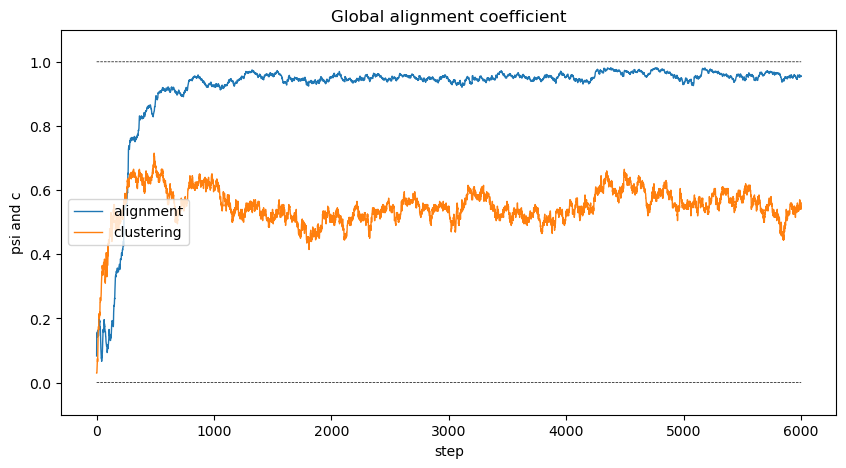

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(psi2, '-', linewidth=1, label='alignment')
plt.plot(c2, '-', linewidth=1, label='clustering')
plt.plot(0 * psi2, '--', color='k', linewidth=0.5)
plt.plot(0 * psi2 + 1, '--', color='k', linewidth=0.5)
plt.title('Global alignment coefficient')
plt.legend()
plt.xlabel('step')
plt.ylabel('psi and c')
plt.ylim([-0.1, 1.1])
plt.show()


## Q1 

Studying the simulation, i can see that when clusters are formed, the low-noise particles remain aligned whereas the high-noise particles tend to defer from the alignment of the cluster. That is, the high-noise particles tend to move more randomly, disrupting the overall order and clustering of the system.

The low-noise particles try to form clusters, but the presence of the high-noise particles makes it harder for the entire system to achieve a coherent structure.
